<a href="https://colab.research.google.com/github/belikerehman/Bandgap-Prediction-Project/blob/main/Myproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymatgen matminer numpy pandas scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 35.5 MB/s eta 0:00:00


In [4]:
from pymatgen.ext.matproj import MPRester

API_KEY = "lbahWvtGcuBySkV3"  # Replace with your key

with MPRester(API_KEY) as mpr:
    # Fetch all materials with Li, Ge, P, S (adjust criteria)
    data = mpr.query(
        criteria={"elements": {"$all": ["Li", "Ge", "P", "S"]}},
        properties=["material_id", "band_gap", "structure"]
    )

# Check if Li₁₀Ge(PS₆)₂ exists in the results
target_material = None
for entry in data:
    if entry['material_id'] == 'mp-696128':  # Replace if MP ID is known
        target_material = entry
        break

print(f"Found {len(data)} materials.")

Found 2 materials.


In [7]:
# Convert Materials Project data (list of dicts) to DataFrame
import pandas as pd
df = pd.DataFrame(data)

# 1. Convert crystal structure to composition
from matminer.featurizers.conversions import StructureToComposition
struct_to_comp = StructureToComposition()
df = struct_to_comp.featurize_dataframe(df, "structure")  # Now works on a DataFrame

# 2. Add elemental features (e.g., atomic number, atomic radius)
from matminer.featurizers.composition import ElementProperty
ep = ElementProperty.from_preset("magpie")
df = ep.featurize_dataframe(df, "composition")

# 3. Prepare features/target
X = df.drop(columns=["material_id", "structure", "composition", "band_gap"])
y = df["band_gap"]

StructureToComposition:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds)} eV")

MAE: 0.30929999999999636 eV


In [9]:
target_features = X[df["material_id"] == "mp-696128"]  # Replace with MP ID
predicted_gap = model.predict(target_features)
print(f"Predicted Band Gap: {predicted_gap[0]} eV")

Predicted Band Gap: 2.3643999999999963 eV


In [26]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f} eV")
print(f"R² Score: {r2:.3f}")


Mean Absolute Error: 0.309 eV
R² Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


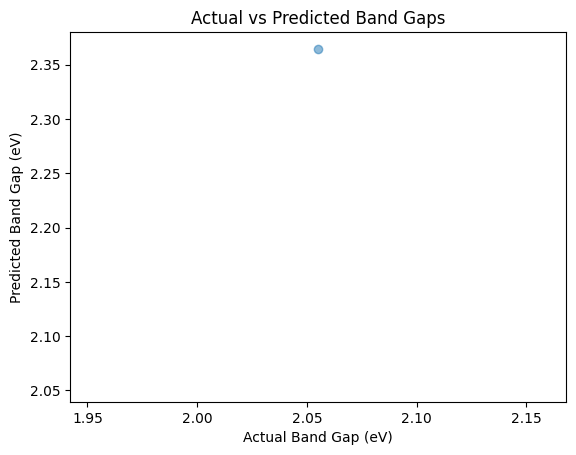

In [27]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.xlabel("Actual Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Actual vs Predicted Band Gaps")
plt.show()

In [28]:
import joblib

# Save the model
joblib.dump(model, "bandgap_model.pkl")

# Load the model later
# model = joblib.load("bandgap_model.pkl")

['bandgap_model.pkl']